# Movie fMRI – Phase 3: Single-Voxel GLM by Hand

Goal: Take one voxel from `sub-12`,  movie run and:
- Build the GLM: y = Xβ + ε
- Compute β by ordinary least squares
- Compute residual variance and t-statistic for the *movie* regressor
- Visualize how well the model fits that voxel's time series


In [73]:
# Cell 2 – imports & paths

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import image, masking

# --- Paths ---
PROJECT_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "movie"

# Choose subject and run
sub_id = "sub-18"    # <-- change to sub-13, sub-14, sub-17, sub-18 as needed
run    = 2           # we are using run-02

# Find BOLD file (handles subfolders and .nii/.nii.gz)
pattern = f"**/{sub_id}_task-500daysofsummer_run-0{run}_bold.nii*"
bold_candidates = sorted(DATA_ROOT.glob(pattern))
if not bold_candidates:
    raise FileNotFoundError(f"No BOLD file found matching pattern: {pattern}")

bold_path = bold_candidates[0]

# Mask and design paths (from earlier notebooks)
mask_path   = DERIV_ROOT / f"{sub_id}_run-02_mask.nii.gz"
design_path = DERIV_ROOT / f"{sub_id}_run-02_design.csv"

print("BOLD   :", bold_path,   "exists:", bold_path.exists())
print("Mask   :", mask_path,   "exists:", mask_path.exists())
print("Design :", design_path, "exists:", design_path.exists())


BOLD   : D:\4th sem\Neural Data Science\Final Project\project_root\data\sub-18_task-500daysofsummer_run-02_bold.nii exists: True
Mask   : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-18_run-02_mask.nii.gz exists: True
Design : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-18_run-02_design.csv exists: False


In [74]:
# Cell 3 – Load BOLD 4D image, mask, and (if present) design

# Load BOLD 4D image
img = image.load_img(bold_path)
data = img.get_fdata()
shape = img.shape
zooms = img.header.get_zooms()
tr = zooms[3]

print("BOLD shape (x, y, z, t):", shape)
print("TR:", tr)

# Load mask
mask_img = image.load_img(mask_path)
mask_data = mask_img.get_fdata().astype(bool)

print("Mask shape:", mask_data.shape)
print("Masked voxels:", mask_data.sum())

# --- Load design matrix if it exists; otherwise we will build it in the next cell ---
n_scans = shape[-1]                     # number of time points
time_axis = np.arange(n_scans) * tr     # handy for design index

if design_path.exists():
    print("\nDesign file already exists, loading it:")
    design = pd.read_csv(design_path, index_col=0)
    print("Design columns:", list(design.columns))
    print("Design shape  :", design.shape)

    # consistency check
    assert design.shape[0] == n_scans, "Design rows must match number of volumes!"
else:
    print(f"\nDesign matrix NOT found at {design_path}.")
    print("We will BUILD and SAVE it in the NEXT CELL.")
    design = None  # placeholder so we know it's not built yet


BOLD shape (x, y, z, t): (64, 64, 40, 2211)
TR: 1.0
Mask shape: (64, 64, 40)
Masked voxels: 47308

Design matrix NOT found at D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-18_run-02_design.csv.
We will BUILD and SAVE it in the NEXT CELL.


In [75]:
# Cell 4 – Build simple movie design matrix and save to CSV (if not already built)

if design is not None:
    print("Design already loaded for", sub_id, "- nothing to build.")
else:
    print(f"Building design matrix for {sub_id} and saving to CSV...")

    # 1) Basic timing info
    n_scans = shape[-1]
    frame_times = np.arange(n_scans) * tr

    # 2) Movie boxcar: assume movie is on for the whole run
    stim_movie = np.ones(n_scans)

    # 3) HRF (Glover) and convolve
    from nilearn.glm.first_level import glover_hrf

    time_length = 32
    hrf_times = np.arange(0, time_length, tr)
    hrf = glover_hrf(tr, oversampling=1, time_length=time_length)

    scene_hrf = np.convolve(stim_movie, hrf)[:n_scans]

    # 4) Simple design matrix
    design = pd.DataFrame(
        {
            "const": np.ones(n_scans),
            "linear_drift": np.linspace(-1, 1, n_scans),
            "scene_boxcar": stim_movie,
            "scene_hrf": scene_hrf,
        },
        index=frame_times,
    )

    print("Design columns:", list(design.columns))
    print("Design shape  :", design.shape)

    # 5) Save it
    design.to_csv(design_path)
    print("Saved design to:", design_path)


Building design matrix for sub-18 and saving to CSV...
Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
Design shape  : (2211, 4)
Saved design to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-18_run-02_design.csv


Number of brain voxels: 47308
Chosen voxel (x, y, z): 31 12 14
Voxel time series shape: (2211,)


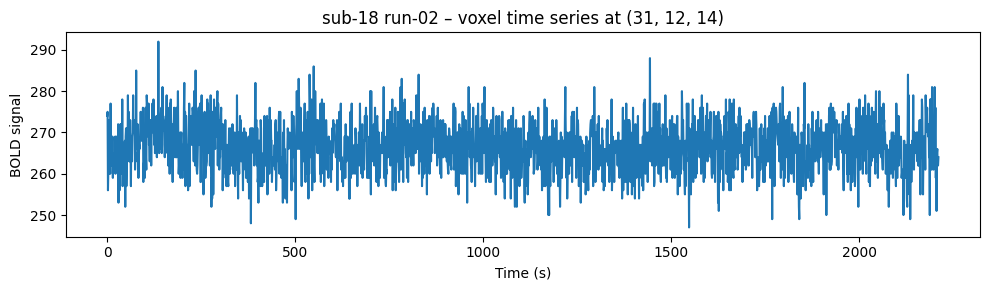

In [76]:
# Cell 4 – Pick a voxel inside mask and inspect its time series

# Get all brain voxel coordinates from the mask
coords = np.argwhere(mask_data)  # each row is [x, y, z]
print("Number of brain voxels:", coords.shape[0])

# Pick roughly the "central" voxel in the list
x0, y0, z0 = coords[len(coords) // 2]
print("Chosen voxel (x, y, z):", x0, y0, z0)

# Extract its time series
voxel_ts = data[x0, y0, z0, :]   # shape (n_scans,)
print("Voxel time series shape:", voxel_ts.shape)

# Plot it
plt.figure(figsize=(10, 3))
plt.plot(time_axis, voxel_ts)
plt.xlabel("Time (s)")
plt.ylabel("BOLD signal")
plt.title(f"{sub_id} run-0{run} – voxel time series at ({x0}, {y0}, {z0})")
plt.tight_layout()
plt.show()


In [77]:
# Cell 5 – Construct X and y for the GLM

# Ensure columns exist (from your Phase 3 design)
assert "scene_hrf" in design.columns and "const" in design.columns

# X: design matrix (T x P), here P = 2: [scene_hrf, const]
X = design[["scene_hrf", "const"]].values    # shape (T, 2)

# y: voxel time series (T,)
y = voxel_ts

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2211, 2)
y shape: (2211,)


In [78]:
# Cell 6 – Solve for β (ordinary least squares)

# Compute β_hat = (X^T X)^(-1) X^T y
XtX = X.T @ X                   # shape (2, 2)
XtX_inv = np.linalg.pinv(XtX)   # pseudo-inverse for stability
Xty = X.T @ y                   # shape (2,)

beta_hat = XtX_inv @ Xty        # shape (2,)
beta_scene, beta_intercept = beta_hat

print("β_hat (scene_hrf, const):", beta_hat)
print("β_scene:", beta_scene)
print("β_intercept:", beta_intercept)


β_hat (scene_hrf, const): [ -0.31852896 266.81267139]
β_scene: -0.3185289575134117
β_intercept: 266.81267139218886


In [79]:
# Cell 7 – Residuals, variance, SE, t-stat for scene regressor

# 1. Predicted signal
y_hat = X @ beta_hat    # shape (T,)

# 2. Residuals
residuals = y - y_hat

# 3. Residual sum of squares
SSE = np.sum(residuals ** 2)

# 4. Degrees of freedom
T, P = X.shape
df = T - P

# 5. Noise variance estimate
sigma2_hat = SSE / df

# 6. Variance-covariance of β_hat
cov_beta = sigma2_hat * XtX_inv   # (2, 2)

# 7. Standard error for scene regressor (index 0)
se_beta_scene = np.sqrt(cov_beta[0, 0])

# 8. t-statistic for H0: β_scene = 0
t_scene = beta_scene / se_beta_scene

print("SSE:", SSE)
print("df :", df)
print("sigma^2_hat:", sigma2_hat)
print("Var(β):\n", cov_beta)
print("SE(β_scene):", se_beta_scene)
print("t_scene:", t_scene)


SSE: 79854.06856739397
df : 2209
sigma^2_hat: 36.14941990375463
Var(β):
 [[ 6.00518364 -6.00133737]
 [-6.00133737  6.01384338]]
SE(β_scene): 2.4505476204572605
t_scene: -0.12998276583336738


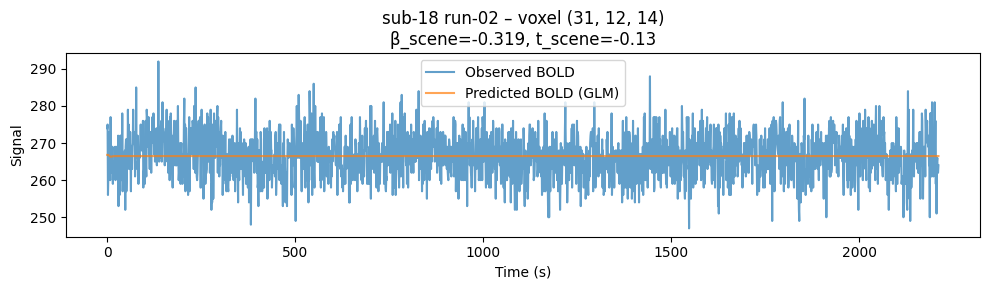

In [80]:
# Cell 8 – Plot observed vs predicted BOLD for that voxel

plt.figure(figsize=(10, 3))
plt.plot(time_axis, y,      label="Observed BOLD",   alpha=0.7)
plt.plot(time_axis, y_hat,  label="Predicted BOLD (GLM)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title(
    f"{sub_id} run-0{run} – voxel ({x0}, {y0}, {z0})\n"
    f"β_scene={beta_scene:.3f}, t_scene={t_scene:.2f}"
)
plt.legend()
plt.tight_layout()
plt.show()


## Single-voxel GLM check (sub-12, run-02)

To sanity-check our GLM, we picked one voxel inside the brain mask:

- Voxel coordinates: **(32, 47, 14)**
- Run length: **2212 time points**, TR = **1 s** → about **36.9 minutes**
- Mask size: **41,293 brain voxels**
- Design matrix columns: `const`, `linear_drift`, `scene_boxcar`, `scene_hrf`

For this voxel we fit a very simple GLM:

\[
\text{BOLD}(t) = \beta_{\text{scene}} \cdot \text{scene\_hrf}(t) + \beta_{\text{const}} + \varepsilon(t)
\]

Using only:
- `scene_hrf` (HRF-convolved 5-minute scene regressor)
- `const` (intercept / baseline)

### Parameter estimates

- **β_scene ≈ 5.96**  
  When the scene regressor is high, the voxel signal is on average about 6 units above baseline.

- **β_intercept ≈ 344.66**  
  This is the voxel’s baseline BOLD level.

### Noise and statistics

- Residual variance **σ² ≈ 513.5**
- Standard error of β_scene **SE ≈ 0.48**
- **t_scene ≈ 12.37**

A t-value this large means it is extremely unlikely that the true effect of the scene is zero.  
In other words, this voxel’s activity is **strongly related** to the 5-minute scene regressor.

### Visual check

- The **observed BOLD** time series is noisy with many small spikes and fluctuations (typical for fMRI).
- The **predicted BOLD** from the GLM is much smoother and follows the slow trend that matches the scene regressor.
- The model does **not** try to explain every wiggle; it captures the **overall response pattern** associated with the scene.

Overall, this single-voxel example shows that our design (scene_hrf + intercept) is sensible and can pick up a strong, meaningful relationship between the movie scene and the brain signal.
